# Boiler Feed Pump Performance Curve Model

Author: Chris Hui
    
Date: 13.10.2017
    
Version 1.51

Purpose: The Muja Engineering Team does not have visible access regarding Boiler Feed Pump (BFP) Performance.
With a lack of visibility, engineers are not able to monitor pump degradation and perform proactive maintenance.
The development of the BFP curve is to enable the engineers to have a continuous and real-time view of our pump
performance. With corrective maintenance costs being significant (in the millions), if proactive maintenance could
be carried out, this could result in sizeable savings. Secondly, this will also allow us to address a question regarding
pump efficiency. Pump efficiency is a key metric to pump performance - if we are able to identify which variables
impact efficiency the most, we will be able to focus on certain PI tags to monitor, rather than a whole bunch. 

# Libraries required
                                                       
* numpy - This may be used for array transformations. Currently it is not in use.                          
* seaborn - This is our visualisation package which will allow us to create aesthetically pleasing plots.   
* pandas - We have used pandas as our primary way of manipulating and storing the data we have extracted.   
* matplotlib - This is the default plotting engine that we have used for our basic plots.                  

In [3]:
import seaborn as sbn
import pandas as pd
import matplotlib.pyplot as plt
import math 
from scipy import stats, integrate
from matplotlib.ticker import MultipleLocator
from sklearn.neighbors import KNeighborsClassifier

# Functions Used
* We needed to define a custom function to show the R Squared Value for the Seaborn Library.                 
* Seaborn in it's current release does not have a function to show the R Squared Values.                      
* Function Source: https://stackoverflow.com/questions/25579227/seaborn-implot-with-equation-and-r2-text                                                                                                           


In [9]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

# Import data and cleanse (Data Integration)  
Source: BFP.csv
    
Logic: I was intending to write a script to connect to the PI Asset Hierarchy Database we    
have in the office. However, as this is intended to be reproducible for other people I have   
opted to use a .CSV file as in my initial input. For subsequent work versions I will create  
a wrapper which will allow Python to talk directly to the Plant Information (PI) System. 

After importing the data, we have had to cleanse it by ensuring we have replaced all null 
values. 

This is checked via the dtypeCount to ensure we have no null-type entries in the dataframe.


In [5]:
file = pd.ExcelFile('BFP_1_Year_Data_C_Pump.xlsx')
sheets = file.sheet_names
df = file.parse('raw_feeds', skiprows=1)

names = ['Date', 'Booster_Pump_Bearing_Temperature', 'BFP_C_Discharge_Pressure',
       'Drive_End_Motor_Vibration', 'Drive_End_Pump_Vibration',
       'Drive_End_Seal_Inlet_Temperature', 'Flow_Rate_(KG/S)',
       'Lubrication_Oil_Cooler_Inlet_Temp',
       'Lubrication_Oil_Filter_Outlet_Temp',
       'Motor_Bearing_Temp_1', 'Motor_Bearing_Temp_2',
       'BFP_C_Motor_Amps', 'Non_Drive_End_Motor_Vibration',
       'Non_Drive_End_Pump_Vibration', 'Non_Drive_End_Seal_Inlet_Temp',
       'Pump_RPM', 'Work_Oil_Cooler_Inlet_Coupling_Temp',
       'Work_Oil_Cooler_Outlet_Coupling_Temperature', 'Generator_Load',
       'Rated_Voltage', 'FW_Water_Temperature', 'Specific_Gravity', 'Gravity',
       'Sulzer_RPM', 'DA_Pressure', 'DA_Conv_Pressure', 'Power_Factor',
       'Motor_Efficiency', 'Order_type', 'Func_Loc_Sec_Label',
       'Func_Loc_Sec_Label_2', 'Part', 'Func_Loc_Prim_Label',
       'Func_Loc_Prim_Label_2', 'Maintenance_Order', 'Text', 'Assignment',
       'Status', 'Actual_start_date', 'Actual_finish date',
       'System Condition']

df.dropna(axis=1, how='all', inplace=True)
df.columns = names
df.replace(to_replace='Configure', value=0, inplace=True)
df.replace(to_replace='Bad', value=0, inplace=True)
df.replace(to_replace='Configure', value=0, inplace=True)
df.replace(to_replace='Comm Fail', value=0, inplace=True)
dtypeCount =[df.iloc[:,i].apply(type).value_counts() for i in range(df.shape[1])]

# Calculation Methodology
## Total Head Formula
Total Hydraulic Head = (Dp - Sp) / Sg  x  G 

where Sp is calculated (Dh + Dsp) where Dh is calculated by applying the constant 9.804139432 to meters.

This will then convert the Meters of the Daerator Head to an equivalent pressure (kPa)      

* Dp = Discharge Pressure
* Sp = Suction Pressure (Dsp + Dh)
* Sg = Specific Gravity Constant (0.886001)
* G= Gravitational Constant (9.8)        
* Dh = Daerator Height
* Dsp = Daerator Shell Pressure                                                                             
                                                                                                                       
Suction Pressure will have to be created by adding the Daerator Shell Pressure with the Daerator Height     

## Efficiency Formula

Efficiency = Net Output / Net Input

* Net Input = SQRT(3) x Motor Amps x Rated Voltage x Power Factor x Motor Efficiency

* Net Output = (Specific Gravity x Gravity x Total Hydraulic Head x Discharge Flow Rate) / 1000

In [ ]:
#df.DA_Pressure = df.DA_Pressure.astype(float)
#df.DA_Conv_Pressure = df.DA_Conv_Pressure.astype(float)
#BFP_C_Discharge_Pressure needs to be converted to kPa so x 1000
df.BFP_C_Discharge_Pressure = df.BFP_C_Discharge_Pressure.values * 1000
df['Suction_Pressure']= df['DA_Pressure'].values + df['DA_Conv_Pressure'].values
#print (df['Suction_Pressure'])
#df.Suction_Pressure = df.Suction_Pressure.astype(float)
#df.BFP_N_Discharge_Pressure = df.BFP_N_Discharge_Pressure.astype(float)

#With Suction Pressure now created we can calculate Total Head and add this as a column
df['Total_Head'] = (df['BFP_C_Discharge_Pressure'].values - df['Suction_Pressure'].values)/(df['Specific_Gravity'].values * df['Gravity'].values)

#Now that we have the Total Head, it is important that we compare the pump revolutions per minute against the target specification
#This is for the Sulzer Pump with a target specification of 6,412 RPMs
df['RPM_%'] = df['Pump_RPM'].values/df['Sulzer_RPM'].values

#Net Input Calculation Below
df['Net_Input'] = math.sqrt(3) * df['BFP_C_Motor_Amps'].values * df['Rated_Voltage'].values * df['Power_Factor'].values * df['Motor_Efficiency'].values  
df['Net_Output'] = (df['Specific_Gravity'].values * df['Gravity'].values * df['Total_Head'].values * df['Flow_Rate_(KG/S)'].values)/1000
df = (df[(df['Net_Output']>0)])

#print (df[(df['Net_Input']>0)].shape)
df['Efficiency_%'] = df['Net_Output'].values / df['Net_Input'].values
#We will need to create an intermediate variable based off our median value as a boolean check
#If the value is > 48.05% it's acceptable so 1. If it's < than that, then 0. 
df['Classification'] = (df['Efficiency_%'] > 0.4805).astype(int)

#Now we want to filter out data frame further with the following conditions
#If the flow rate is 0KG/S, Total Head is -ve AND RPM <=0, remove these from the dataframe
#If any of these conditions are met - we will remove the data from the dataframe as the pump is offline.
#df = df[((df['Flow_Rate_(KG/S)']>0) & (df['Pump_RPM']>0) & (df['Total_Head']>0))]

#df.reset_index(drop=True, inplace=True)
#df.drop(['Date','Date_left','Date_right'], axis=1, inplace=True)



# Modelling the data - Exploratory Data Analysis (EDA)
As a first pass performance measure, we need to plot Total Head (M) against Flow Rate (KG/S). 

This is  not enough however to determine pump degradation. Our hypotheses is that motor efficiency is a key      
indicator of performance degradation. 

There should be a relationship between Total Head and Efficiency.

Our analysis will need two parts: 
    
1. Create a Boiler Feed Pump Model incorporating Total Head and Efficency. 

2.  Understand the key variables which drive efficiency. In Engineering, we are aware efficiency 
is key to pump degradation. However, we do not know the weightings of each variables significance.     

#### Theoretical specifications of motor speed (RPM) indicate a pump curve of 25%,50%,75%,90% and 100%  should be fitted. 

### The first question we need to address is: Is this valid?    

To address this we want to understand the shape of our data. We have opted to use a KDE plot which     
shows a CDF (X-axis) overlaid with a density function (Y-axis). From this we can see that the density 
is highest at ~ 90%. Hence, it would not make sense for 25%, 50%, 75% or 100% curves to be fitted.    


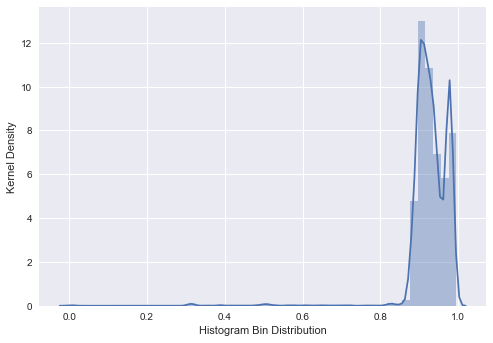

In [39]:
distPlot = sbn.distplot(df['RPM_%'].values, kde=True)
plt.xlabel('Histogram Bin Distribution')
plt.ylabel('Kernel Density')
plt.show()

##### Is this valid?

Our analysis reveals that the majority of observations are in the 90% range.

Hence, it wouldn't make sense for us to create a curve for 25%,50%,75% as there is no substantial data to support these curves.

Taking this into account, the next question we should explore is:
    
1. What does the relationship between Total Head versus Flow Rate look like if we include all data and
2. If we include ONLY 90%?

Are we able to see a difference in trend?


Plotting


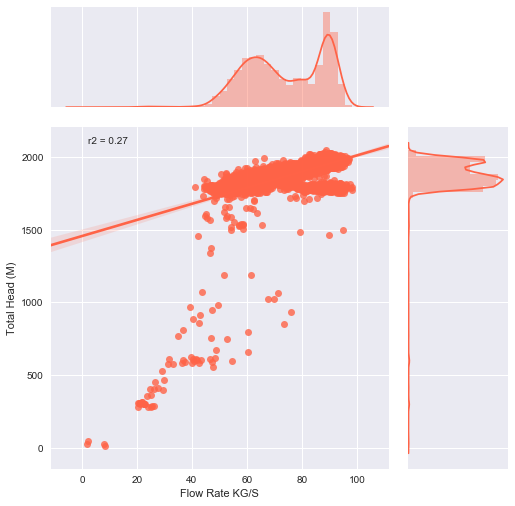

Filter to 90% as per KDE Plot Density


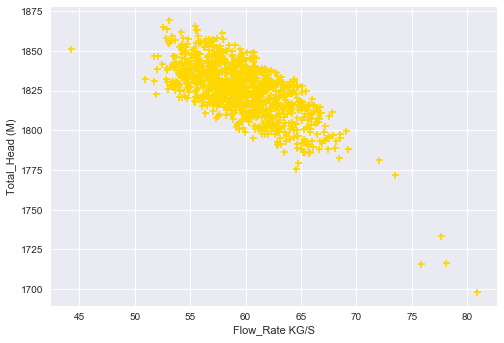

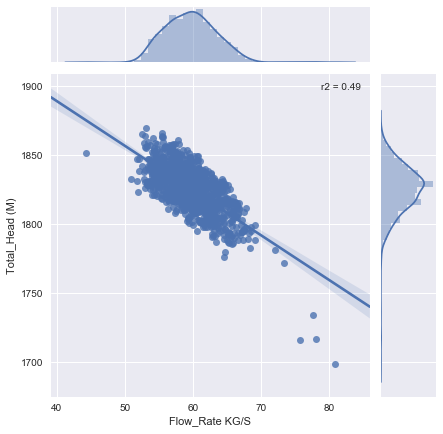

In [40]:
# Set up the matplotlib figure
#Create Scatter Plot highlighting Total Head vs. Flow Rate
#totalHeadvsFlowRate = df[['Total Head','Flow_Rate_(KG/S)']]
sbn.jointplot(df['Flow_Rate_(KG/S)'].values, df['Total_Head'].values, kind="reg", stat_func=r2, size=7, ratio=3, color='tomato')
plt.xlabel('Flow Rate KG/S')
plt.ylabel('Total Head (M)')
print("Plotting")
plt.show()
#Density = 900.0539KG/M3
#Flow Multiplier = 1/ (Density/1000)
print("Filter to 90% as per KDE Plot Density")

df2 = df
df2 = df2[(df2['RPM_%']>0.895)& (df2['RPM_%']<0.905)]
plt.scatter(x=df2['Flow_Rate_(KG/S)'].values, y=df2['Total_Head'].values, marker='+', color='gold')
plt.xlabel('Flow_Rate KG/S')
plt.ylabel('Total_Head (M)')
plt.show()

#Now that we have applied the filtering to our scatter plot - let's take another look at the R Squared Value
#Please note that R Squared is by no means an ideal indicator of relationship as it can only increase as
#more variables are added
sbn.jointplot(df2['Flow_Rate_(KG/S)'].values, df2['Total_Head'].values, kind="reg", stat_func=r2)
plt.xlabel('Flow_Rate KG/S')
plt.ylabel('Total_Head (M)')
plt.show()


In [ ]:
## So what do the graphs tell us?
A R^2 value of 49% doesn't indicate a particularly strong relationship, but it does smooth out the curve from being bimodal, to unimodal.

## Could we perhaps use a different type of curve fitting to accurately portray the relationship between Total Head and Flow Rate?

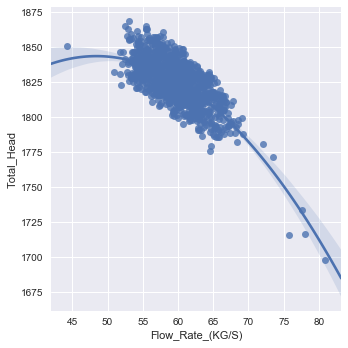

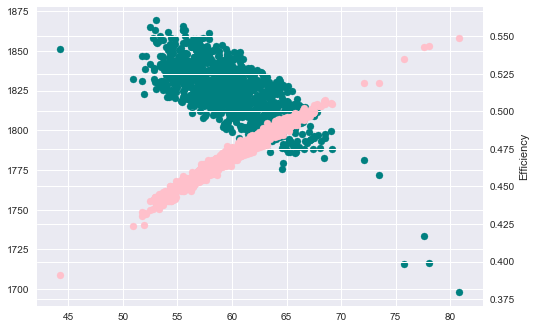

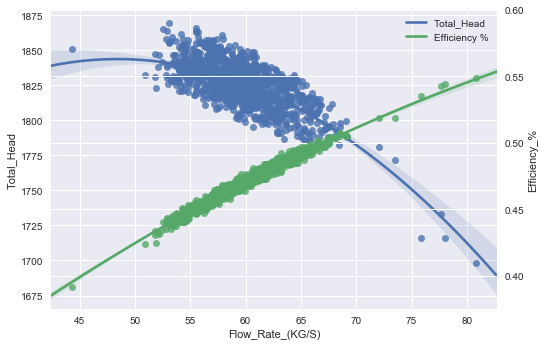

In [41]:
df3 = df2[['Flow_Rate_(KG/S)', 'Total_Head']]
df4 = df2[['Flow_Rate_(KG/S)', 'Efficiency_%']]

sbn.lmplot(x="Flow_Rate_(KG/S)", y="Total_Head", data=df3, order=2)
plt.show()
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.scatter(df2['Flow_Rate_(KG/S)'], df2['Total_Head'], color='teal')
ax2.scatter(df2['Flow_Rate_(KG/S)'], df2['Efficiency_%'], color='pink')
ax2.set_ylabel('Efficiency')
plt.show()

fig, ax = plt.subplots()

ax2 = ax.twinx()

sbn.regplot(x="Flow_Rate_(KG/S)", y="Total_Head", data=df3, order=2, ax=ax)
sbn.regplot(x="Flow_Rate_(KG/S)", y="Efficiency_%", data=df4, order=2, ax=ax2)
ax2.set_ylim([0.375,0.60])
ax2.yaxis.set_major_locator(MultipleLocator(0.05))
ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], labels=["Total_Head", "Efficiency %"])
plt.show()





It turns out by applying a 2nd order polynomial function to our Total Head vs Flow Rate curve, we are able to mirror a much
smoother relationship than that of a linear relationship. 

Additionally, we were also able to apply the same logic to our 'Efficiency' curve
to identify optimal operating bands the pump should be in.


## So, we now have a series of curves which monitor pump performance.

# HOWEVER

## Do we have a good understanding of the variables which impact efficiency?

In Engineering, efficiency is one of the key measures we are concerned about.

Taking this into account, we need to understand - what does 'inefficient' efficiency look like?

The target specifications indicate an efficiency of around 78% is 'good'. Historical data does not support this.

As such, we will use another measure which will be 'the 'yearly' average.

It turns out, we don't have a complete view of all the variables and the weightings regarding how they impact efficiency.

## With this in mind, let's run a first pass where we look at the variables through a heat-map to identify promising variables.

## After this is done, we will run this through a CART tree to identify the key variables which impact efficiency.



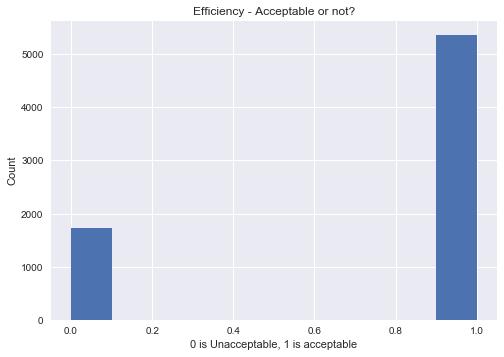

The ratio of acceptable efficiency to unacceptable is: 
0.76 % acceptable efficiency
0.24 % unacceptable efficiency
Index(['Booster_Pump_Bearing_Temperature', 'BFP_C_Discharge_Pressure',
       'Drive_End_Motor_Vibration', 'Drive_End_Pump_Vibration',
       'Drive_End_Seal_Inlet_Temperature', 'Flow_Rate_(KG/S)',
       'Lubrication_Oil_Cooler_Inlet_Temp',
       'Lubrication_Oil_Filter_Outlet_Temp', 'Motor_Bearing_Temp_1',
       'Motor_Bearing_Temp_2', 'BFP_C_Motor_Amps',
       'Non_Drive_End_Motor_Vibration', 'Non_Drive_End_Pump_Vibration',
       'Non_Drive_End_Seal_Inlet_Temp', 'Pump_RPM',
       'Work_Oil_Cooler_Inlet_Coupling_Temp',
       'Work_Oil_Cooler_Outlet_Coupling_Temperature', 'Generator_Load',
       'Rated_Voltage', 'FW_Water_Temperature', 'Suction_Pressure',
       'Total_Head', 'RPM_%', 'Classification'],
      dtype='object')


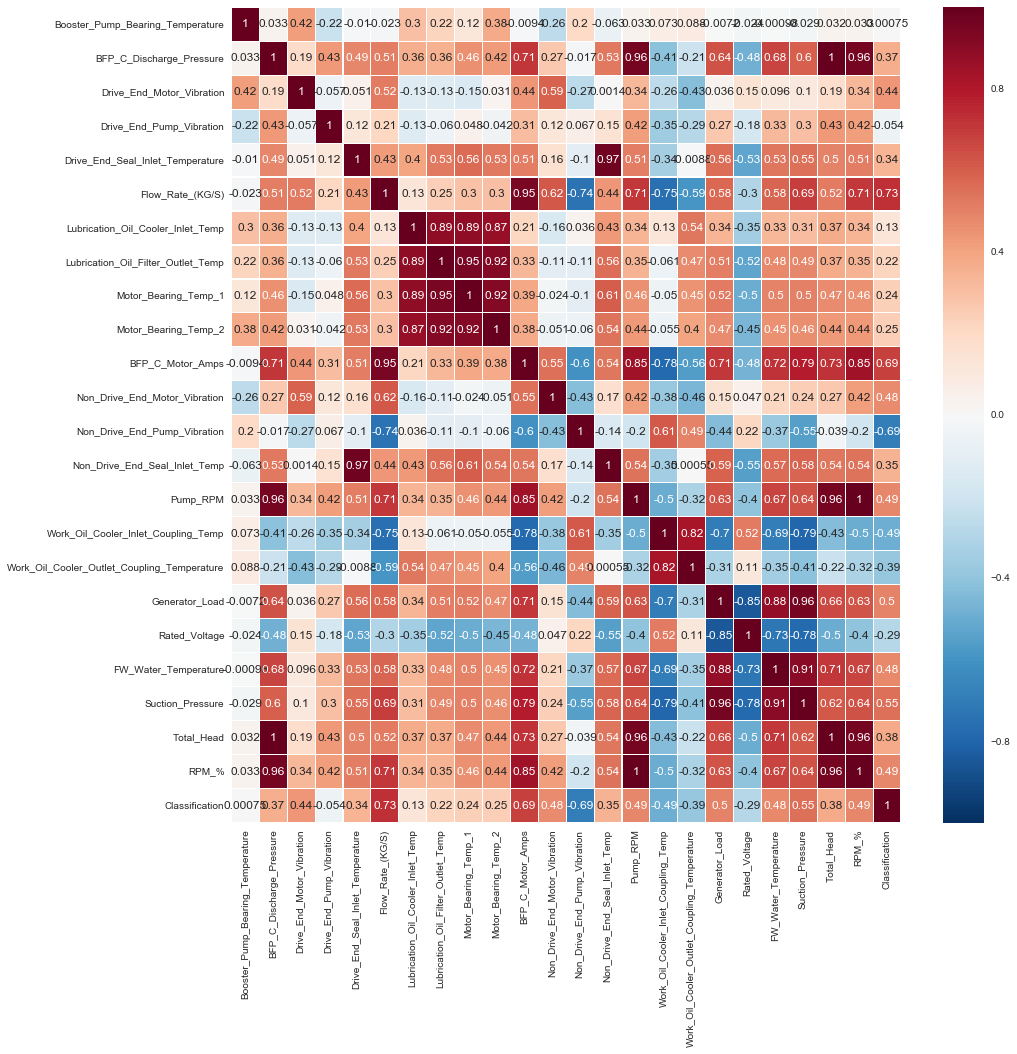

In [42]:
plt.hist(df['Classification'].values, bins=10)
plt.xlabel('0 is Unacceptable, 1 is acceptable')
plt.ylabel('Count')
plt.title('Efficiency - Acceptable or not?')
plt.show()

print ("The ratio of acceptable efficiency to unacceptable is:" + " " + '\n' + str(round(df['Classification'].sum()/len(df['Classification']),2)) + ' % acceptable efficiency')
print ((str(1-(round(df['Classification'].sum()/len(df['Classification']),2))))+ " % unacceptable efficiency")
#We will need to plot out a correlation matrix and exclude the variables which are static. ns denotes non-static. 
df_ns = df
df_ns = df_ns.drop(['DA_Pressure', 'DA_Conv_Pressure','Specific_Gravity', 'Gravity', 'Sulzer_RPM', 'Power_Factor', 'Motor_Efficiency', 'Order_type', 'Func_Loc_Sec_Label',
       'Func_Loc_Sec_Label_2', 'Part', 'Func_Loc_Prim_Label', 'Func_Loc_Prim_Label_2', 'Maintenance_Order', 'Text', 'Assignment',
       'Status', 'Actual_start_date', 'Actual_finish date', 'System Condition','Date'], axis=1)
#As efficiency is calculated via net output / net input, we will also need to remove these fields else there will be multicolinearity developed.
df_ns = df_ns.drop(['Efficiency_%', 'Net_Input', 'Net_Output'], axis=1)

print (df_ns.columns)
#Filter by 90% RPM
#df_ns = df_ns[(df_ns['RPM_%']>0.895)&(df_ns['RPM_%']<0.905)]
#print (df_ns.shape)
#Try this change - filter to 90% RPM
#df_ns = df_ns[(df_ns['RPM_%']>0.895)&(df_ns['RPM_%']<0.905)]
corr = df_ns.corr()
corr = (corr)

fig, ax = plt.subplots(figsize=(15,15)) 
sbn.heatmap(corr, annot=True,linewidths=.1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)
plt.show()



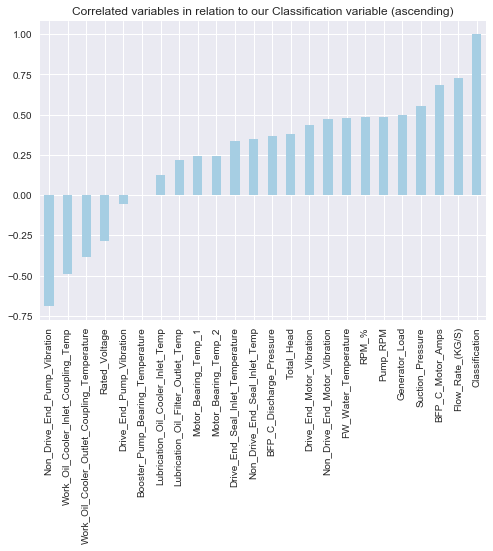

In [43]:
vals = corr['Classification'].sort_values(ascending=True)
corr['Classification'].sort_values(ascending=True).plot(kind='bar', colormap='Paired')
plt.title('Correlated variables in relation to our Classification variable (ascending)')
plt.show()


# Success

Excellent - with the CART, we can now clearly see that the variables which impact efficiency are:

1. Flow Rate
2. Motor Amps
3. RPM %

This makes sense from an engineering perspective as the heavier the pump is running, the higher the flow rate.

With a higher flow rate, more energy is required so would expect to see a shift in Amps consumption.

Lastly with a higher flow rate and a higher pump speed, the Revolutions per minute would also be a key indicator of the
amount of torque expressed by the pump.


Index(['Booster_Pump_Bearing_Temperature', 'BFP_C_Discharge_Pressure',
       'Drive_End_Motor_Vibration', 'Drive_End_Pump_Vibration',
       'Drive_End_Seal_Inlet_Temperature', 'Flow_Rate_(KG/S)',
       'Lubrication_Oil_Cooler_Inlet_Temp',
       'Lubrication_Oil_Filter_Outlet_Temp', 'Motor_Bearing_Temp_1',
       'Motor_Bearing_Temp_2', 'BFP_C_Motor_Amps',
       'Non_Drive_End_Motor_Vibration', 'Non_Drive_End_Pump_Vibration',
       'Non_Drive_End_Seal_Inlet_Temp', 'Pump_RPM',
       'Work_Oil_Cooler_Inlet_Coupling_Temp',
       'Work_Oil_Cooler_Outlet_Coupling_Temperature', 'Generator_Load',
       'Rated_Voltage', 'FW_Water_Temperature', 'Suction_Pressure',
       'Total_Head', 'RPM_%'],
      dtype='object')


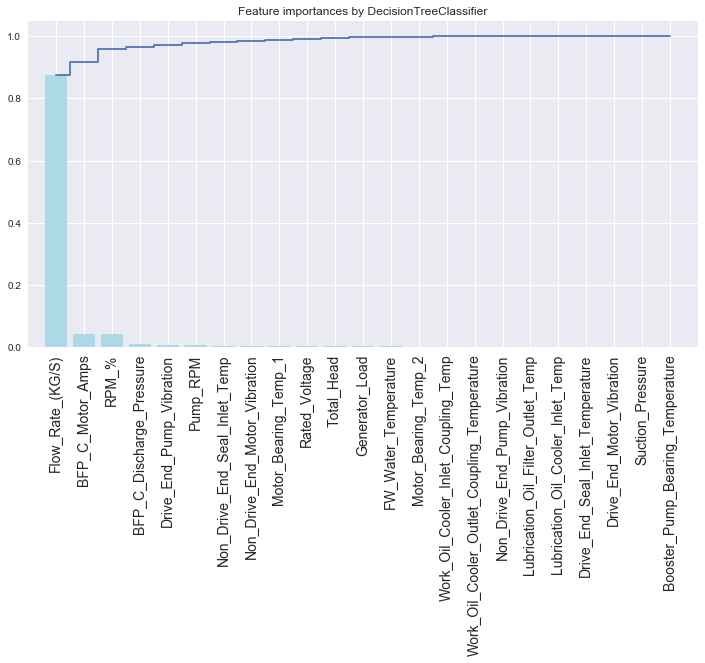

In [44]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# Create train and test splits
target_name = 'Classification'

X = df_ns.drop(['Classification'], axis=1)
print (X.columns)
#Drop vibrations if this showing as the most significant

#Y is our predictor variable. We are aiming to understand what are the variables which impact efficiency.
y= df_ns[target_name]
#We use stratify to maintain our ratio between test/train data points. We have more acceptable (58%) than 'unacceptable' results)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)

dtree = tree.DecisionTreeClassifier(
    max_depth=50,
    criterion='entropy'
    #class_weight="balanced",
    #min_weight_fraction_leaf=0.1
    )
dtree = dtree.fit(X_train,y_train)

## plot the importances ##
importances = dtree.feature_importances_
feat_names = df_ns.columns


indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()





In [ ]:
#Appendix - Extra ML Models that were built to test our Python ML Capabilities

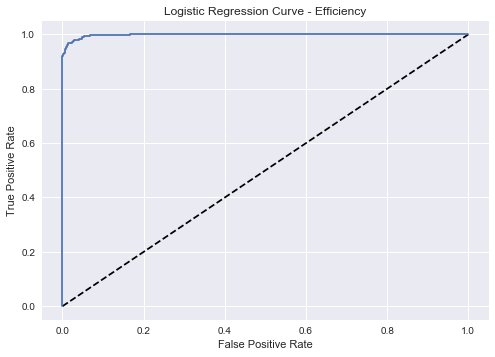

[[ 414   16]
 [  26 1315]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95       430
          1       0.99      0.98      0.98      1341

avg / total       0.98      0.98      0.98      1771

logreg score is:0.97628458498
AUC is:0.998076756326
5-fold CV score is:[ 0.96332863  0.97600565  0.98446328  0.97033898  0.96539548]
[[ 0.17479308  0.88180964  0.21116115 -0.60989135  0.64707079  7.08264486
  -0.49737978  0.5097113   0.40529054  0.38451621 -0.58520828  0.31727621
  -2.62805446 -0.10734375 -0.3543124  -1.51384084 -0.31569307  0.54475914
  -1.00303601 -0.25326669 -0.10684198  0.78570686 -0.3543124 ]]


In [45]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

X = scale(df_ns.drop(['Classification'], axis=1))
#print (X.shape)
y= df_ns['Classification']
#print (y)
#print (y.shape)
#Instantiate the logreg object
logreg= LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=21, stratify=y)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Logistic Regression on Efficiency')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Curve - Efficiency')
plt.show()

logic_AUC = roc_auc_score(y_test, y_pred_prob)
cv_results = cross_val_score(logreg, X,y, cv=5)
print (confusion_matrix(y_test, y_pred))
print (classification_report(y_test,y_pred))
print ("logreg score is:" + str(logreg.score(X_test,y_test)))
print ("AUC is:" + str(logic_AUC))
print ("5-fold CV score is:" + str(cv_results))

print (logreg.coef_)



In [46]:
#We will try a KNN model with scaled variables to see if this provides a similar fit
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=21, stratify=y)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print (knn.score(X_test, y_test))
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
print (knn_roc_auc)


0.96
0.959763033518


In [47]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=5, 
    #min_weight_fraction_leaf=0.02 
    )
rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.98
             precision    recall  f1-score   support

          0       0.97      0.98      0.97       516
          1       0.99      0.99      0.99      1609

avg / total       0.99      0.99      0.99      2125



In [48]:
#Gradient Boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
ada.fit(X_train,y_train)
print ("\n\n ---AdaBoost Model---")
ada_roc_auc = roc_auc_score(y_test, ada.predict(X_test))
print ("AdaBoost AUC = %2.2f" % ada_roc_auc)
print(classification_report(y_test, ada.predict(X_test)))




 ---AdaBoost Model---
AdaBoost AUC = 0.98
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       516
          1       0.99      0.99      0.99      1609

avg / total       0.99      0.98      0.98      2125



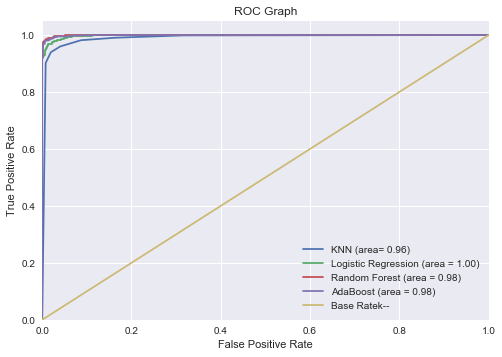

In [49]:
# Create ROC Graph
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
kfpr, ktpr, k_threshholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, ada_thresholds = roc_curve(y_test, ada.predict_proba(X_test)[:,1])

#Plot Knn Model ROC
plt.plot(kfpr, ktpr, label='KNN (area= %0.2f)' % knn_roc_auc)

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logic_AUC)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# Plot AdaBoost ROC
plt.plot(ada_fpr, ada_tpr, label='AdaBoost (area = %0.2f)' % ada_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()